# Mapping GDELT Events

## Requirements

In [ ]:
!pip install --user arcgis
!pip install --user gdelt

## Import modules

In [76]:
from arcgis.gis import GIS
from arcgis.features import GeoAccessor as geo
from datetime import date
from gdelt import gdelt as gdelt_client
import matplotlib.pyplot as plot
import seaborn

## Getting GDELT events of today
Date must be formatted as a string.

In [86]:
def get_events(date):
    client = gdelt_client(version=2)
    events = client.Search(date.strftime("%Y %m %d"), table="events", coverage=True)
    del client
    return events

def get_today_events():
    return get_events(date.today())

In [87]:
events = get_today_events()
events.describe()

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,IsRootEvent,QuadClass,GoldsteinScale,NumMentions,NumSources,...,Actor1Geo_Type,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Type,Actor2Geo_Lat,Actor2Geo_Long,ActionGeo_Type,ActionGeo_Lat,ActionGeo_Long,DATEADDED
count,5.514100e+04,5.514100e+04,55141.000000,55141.000000,55141.000000,55141.000000,55141.000000,55141.000000,55141.000000,55141.000000,...,55141.000000,48005.000000,48005.000000,55141.000000,37668.000000,37668.000000,55141.000000,53750.000000,53750.000000,5.514100e+04
mean,9.109999e+08,2.020021e+07,202002.042056,2019.990479,2020.176114,0.551350,1.698736,0.746049,4.954118,1.071254,...,2.458407,30.737459,-4.422312,1.914274,30.854447,-2.081389,2.765819,30.647338,-5.401693,2.020031e+13
std,2.297665e+04,1.126601e+03,11.266966,0.112672,0.112571,0.497361,1.087815,4.380981,4.536820,0.550778,...,1.507687,19.785698,79.733553,1.676502,19.729373,78.913764,1.312028,19.913036,80.154098,4.197677e+04
min,9.109620e+08,2.010031e+07,201003.000000,2010.000000,2010.194500,0.000000,1.000000,-10.000000,1.000000,1.000000,...,0.000000,-85.622100,-177.900000,0.000000,-85.622100,-177.900000,0.000000,-85.622100,-177.900000,2.020031e+13
25%,9.109801e+08,2.020031e+07,202003.000000,2020.000000,2020.186300,0.000000,1.000000,-2.000000,2.000000,1.000000,...,1.000000,25.252200,-80.072800,0.000000,25.286700,-78.205700,2.000000,25.252200,-80.906600,2.020031e+13
50%,9.109988e+08,2.020031e+07,202003.000000,2020.000000,2020.186300,1.000000,1.000000,1.900000,4.000000,1.000000,...,3.000000,35.750000,3.366670,2.000000,35.750000,6.000000,3.000000,35.744900,2.000000,2.020031e+13
75%,9.110190e+08,2.020031e+07,202003.000000,2020.000000,2020.186300,1.000000,2.000000,3.400000,7.000000,1.000000,...,4.000000,42.149700,53.000000,4.000000,42.149700,53.000000,4.000000,42.149700,53.000000,2.020031e+13
max,9.110414e+08,2.020031e+07,202003.000000,2020.000000,2020.186300,1.000000,4.000000,10.000000,114.000000,16.000000,...,5.000000,72.000000,178.133000,5.000000,72.000000,178.133000,5.000000,72.000000,178.133000,2.020031e+13


## Plot the number of sources
We are using a logarithmic scale for plotting the number of sources.

Text(0,0.5,'Count')

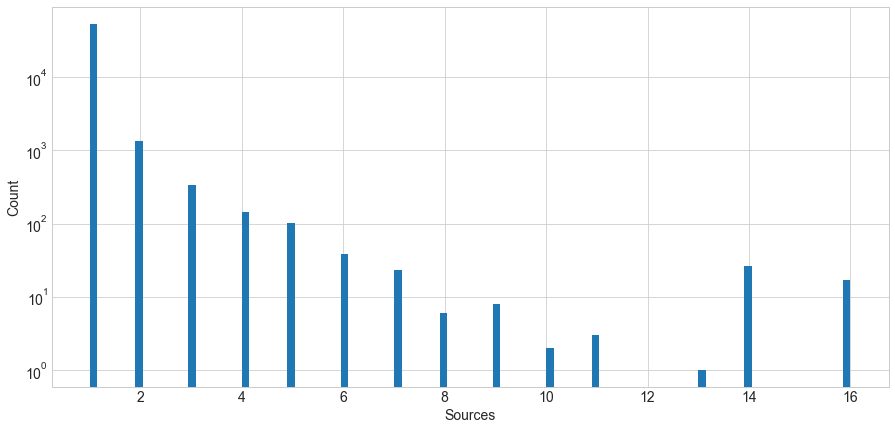

In [88]:
seaborn.set_style("whitegrid")
plot.rcParams["figure.figsize"] = (15, 7)

figure, axis = plot.subplots()
events["NumSources"].hist(ax=axis, bins=100)
axis.set_yscale("log")
axis.tick_params(labelsize=14)
axis.set_xlabel("Sources", fontsize=14)
axis.set_ylabel("Count", fontsize=14)

## Connect to ArcGIS Online anonymously

In [89]:
gis = GIS()

## Display a map of europe
***Hint:*** *map.basemaps shows a list of all available basemaps*

In [90]:
def get_europe_map():
    focus_map = gis.map("Europe")
    focus_map.basemap = "dark-gray-vector"
    return focus_map

focus_map = get_europe_map()

In [91]:
focus_map

MapView(layout=Layout(height='400px', width='100%'))

## Create a spatial dataframe for mapping the events from the pandas dataframe
We are using the ActionGeo_Long and ActionGeo_Lat for locating the events. The spatial reference is WGS84 having EPSG-Code of 4326.
- Extract only the columns relevant for mapping and having a simple type (e.g. int64, float64)
- We are dropping all records having "not a number" for latitude or longitude
- We are slicing and creating a deep copy from the events dataframe

In [97]:
mapping_events = events[["GLOBALEVENTID", 
                         "ActionGeo_FullName", 
                         "ActionGeo_Long", 
                         "ActionGeo_Lat", 
                         "NumMentions", 
                         "SOURCEURL"]].dropna(subset=["ActionGeo_Lat", "ActionGeo_Long"]) 
geo_events = geo.from_xy(mapping_events, x_column="ActionGeo_Long", y_column="ActionGeo_Lat", sr=4326)
geo_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53750 entries, 0 to 55140
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   GLOBALEVENTID       53750 non-null  int64   
 1   ActionGeo_FullName  53750 non-null  object  
 2   ActionGeo_Long      53750 non-null  float64 
 3   ActionGeo_Lat       53750 non-null  float64 
 4   NumMentions         53750 non-null  int64   
 5   SOURCEURL           53750 non-null  object  
 6   SHAPE               53750 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 3.3+ MB


## Display a subset of GDELT events on the map
- Sort the events by using the number of mentions in all source documents. The number of mentions could be used to determine how important the event is. Multiple references within a single document are counted too.

In [98]:
del focus_map
focus_map = get_europe_map()
top_mapping_events = mapping_events.sort_values(by="NumMentions", ascending=False).head(n=1000)
top_geo_events = geo.from_xy(top_mapping_events, x_column="ActionGeo_Long", y_column="ActionGeo_Lat", sr=4326)
top_geo_events.spatial.plot(map_widget=focus_map)
focus_map

MapView(layout=Layout(height='400px', width='100%'))

## Display the GDELT events using a heatmap
We are creating a new map widget and convert all "mapping events" to a spatial data frame.

In [99]:
del heat_focus_map
heat_focus_map = get_europe_map()
geo_events.spatial.plot(map_widget=heat_focus_map, renderer_type="h")
heat_focus_map

MapView(layout=Layout(height='400px', width='100%'))